<a href="https://colab.research.google.com/github/AndrewstheBuilder/VideoSemanticSearch_JiuJitsu/blob/main/LabelData_VideoSemanticSearch_JiuJitsu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Youtube Link i wanted to test: https://www.youtube.com/watch?v=HkwFwGYtqfk
#seconds to get frames from: 30-390.

In [5]:
!pip install yt-dlp opencv-python


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.1 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.3 MB/s eta 0:00:00


In [14]:
import yt_dlp

def download_video_segment_without_audio(url, output_filename):
    ydl_opts = {
        'format': 'bestvideo[ext=mp4][height<=360]/best',  # Limit video to 480p or lower to save space
        'outtmpl': output_filename,
        'quiet': True,
        'postprocessors': [{
            'key': 'FFmpegMetadata',  # This moves metadata to the beginning of the file for seeking
            'add_metadata': True
        }],
        'postprocessor_args': [
            '-movflags', 'faststart'  # This flag is critical for enabling seeking
        ],
    }
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])

# Example usage
youtube_link = "https://www.youtube.com/watch?v=HkwFwGYtqfk"
output_video = 'video_segment.mp4'

download_video_segment_without_audio(youtube_link, output_video)


In [15]:
import cv2
import os

def extract_and_save_frames(video_file, output_folder, interval=30):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(video_file)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)  # Get frames per second
    # print('frame_rate',frame_rate)
    frame_rate = round(frame_rate)
    # print('frame rate after rounding:',frame_rate)
    frame_count = 0
    success = True

    while success:
        success, frame = cap.read()
        # print('success:',success)
        # print('frame:',frame)
        # print('frame_rate * interval',frame_rate * interval)
        # print('frame_count',frame_count)
        # print('frame_count % (frame_rate * interval)',frame_count % (frame_rate * interval))
        if not success:
            break
        # Save only every N-th frame (based on interval)
        # print('frame_count',frame_count)
        if frame_count % (frame_rate * interval) == 0:
            frame_filename = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted frames to {output_folder}")

# Example usage: Extract 1 frame every 1 second
output_folder = "/content/video_frames"
extract_and_save_frames(output_video, output_folder, interval=3)


Extracted frames to /content/video_frames


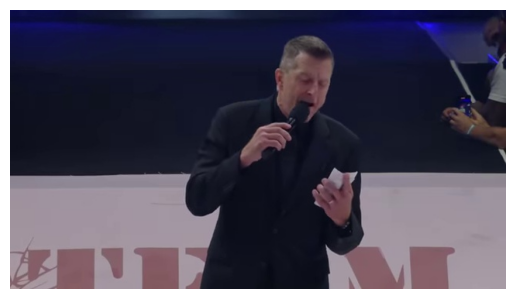

Displaying frame 5/486: /content/video_frames/frame_0360.jpg


In [22]:
import os
import cv2
import ipywidgets as widgets
from IPython.display import display, clear_output
import csv
import matplotlib.pyplot as plt
import re

# Function to extract frame number from filename
def extract_frame_number(filename):
    """Extracts the frame number from the filename (assumes the format frame_XXXX.jpg)."""
    match = re.search(r"frame_(\d+)\.jpg", filename)
    return int(match.group(1)) if match else -1

# Initialize variables
output_folder = "/content/video_frames"
labels_file = "frame_labels.csv"  # To save the labels

# Updated sorting of frame_list based on frame number
frame_list = sorted(
    [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.jpg')],
    key=extract_frame_number  # Sort based on extracted frame number
)

current_index = 0
labels = {}

# Create widgets
label_dropdown = widgets.Dropdown(
    options=['standing', 'pinning', 'guarded', 'none'],
    value='none',
    description='Label:'
)
next_button = widgets.Button(description="Next Frame")
prev_button = widgets.Button(description="Previous Frame")
save_button = widgets.Button(description="Save Label")
save_to_csv = widgets.Button(description="Save to CSV")

# Function to display the current frame
def display_frame(index):
    clear_output(wait=True)
    frame_path = frame_list[index]
    frame = cv2.imread(frame_path)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Display frame
    plt.imshow(frame_rgb)
    plt.axis('off')
    plt.show()

    # Show current index and label
    print(f"Displaying frame {index+1}/{len(frame_list)}: {frame_path}")
    display(widgets.HBox([prev_button, next_button, label_dropdown, save_button, save_to_csv]))

# Function to save the current label
def save_label(b):
    global current_index
    labels[frame_list[current_index]] = label_dropdown.value
    print(f"Label saved for frame {frame_list[current_index]}: {label_dropdown.value}")

# Function to go to the next frame
def next_frame(b):
    global current_index
    if current_index < len(frame_list) - 1:
        current_index += 1
        display_frame(current_index)

# Function to go to the previous frame
def prev_frame(b):
    global current_index
    if current_index > 0:
        current_index -= 1
        display_frame(current_index)

# Initial display
display_frame(current_index)

# Function to save all labels to a CSV file
def save_labels_to_csv(b=None):
    with open(labels_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Frame", "Label"])
        for frame, label in labels.items():
            writer.writerow([frame, label])
    print(f"All labels saved to {labels_file}")

# Optionally save all labels to CSV when done
# save_labels_to_csv()

# Attach button events
next_button.on_click(next_frame)
prev_button.on_click(prev_frame)
save_button.on_click(save_label)
save_to_csv.on_click(save_labels_to_csv)


In [23]:
!zip -r /content/video_frames.zip /content/video_frames

  adding: content/video_frames/ (stored 0%)
  adding: content/video_frames/frame_14400.jpg (deflated 1%)
  adding: content/video_frames/frame_11430.jpg (deflated 1%)
  adding: content/video_frames/frame_9810.jpg (deflated 0%)
  adding: content/video_frames/frame_27450.jpg (deflated 1%)
  adding: content/video_frames/frame_40140.jpg (deflated 1%)
  adding: content/video_frames/frame_23220.jpg (deflated 1%)
  adding: content/video_frames/frame_18270.jpg (deflated 1%)
  adding: content/video_frames/frame_43020.jpg (deflated 1%)
  adding: content/video_frames/frame_24030.jpg (deflated 1%)
  adding: content/video_frames/frame_34920.jpg (deflated 1%)
  adding: content/video_frames/frame_41130.jpg (deflated 1%)
  adding: content/video_frames/frame_3420.jpg (deflated 1%)
  adding: content/video_frames/frame_41760.jpg (deflated 1%)
  adding: content/video_frames/frame_17280.jpg (deflated 1%)
  adding: content/video_frames/frame_8820.jpg (deflated 1%)
  adding: content/video_frames/frame_5490.jp

In [27]:
# Organize video frames into sub directories corresponding to classes
import pandas as pd

# Load the csv with the labels
labels_df = pd.read_csv('/content/frame_labels.csv')
# labels_df.front()

# Define the base dataset directory in Colab
dataset_dir = '/content/dataset/'

# Ensure the class directories exist (lowercase class names)
classes = ['none', 'standing', 'pinning', 'guarded']
for class_name in classes:
    os.makedirs(os.path.join(dataset_dir, class_name), exist_ok=True)

In [29]:
import shutil
# Function to copy files based on the CSV labels
def copy_files_to_class_directories(df, base_dir):
    for _, row in df.iterrows():
        frame_path = row['Frame']
        label = row['Label']
        class_dir = os.path.join(base_dir, label)

        # Ensure the frame path exists and copy the file
        if os.path.exists(frame_path):
            shutil.copy(frame_path, class_dir)
        else:
            print(f"File {frame_path} does not exist.")

# Copy files into the respective directories based on the CSV
copy_files_to_class_directories(labels_df, dataset_dir)

print(f"Files have been copied into class directories under {dataset_dir}.")

Files have been copied into class directories under /content/dataset/.


In [30]:
!zip -r /content/dataset.zip /content/dataset

  adding: content/dataset/ (stored 0%)
  adding: content/dataset/guarded/ (stored 0%)
  adding: content/dataset/guarded/frame_11430.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_23220.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_20520.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_17100.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_20970.jpg (deflated 2%)
  adding: content/dataset/guarded/frame_30060.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_35370.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_30780.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_33480.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_20700.jpg (deflated 2%)
  adding: content/dataset/guarded/frame_33390.jpg (deflated 1%)
  adding: content/dataset/guarded/frame_20790.jpg (deflated 2%)
  adding: content/dataset/guarded/frame_26010.jpg (deflated 2%)
  adding: content/dataset/guarded/frame_27090.jpg (deflated 1%)
  adding: content/